## Tutorial 4 - General Aircraft Simulation
Welcome to this tutorial on simulating a general aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## 1. Header and Imports


The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [10]:
# Cessna_172.py
# 
# ----------------------------------------------------------------------
#   Imports
# ----------------------------------------------------------------------

import RCAIDE
from RCAIDE.Framework.Core                                     import Units  
from RCAIDE.Library.Methods.Powertrain.Converters.Rotor        import design_propeller 
from RCAIDE.Library.Plots                                      import *    
 
import matplotlib.pyplot as plt
import numpy as np 
import os 
import sys
sys.path.insert(0,(os.path.dirname(os.getcwd())))

## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network

The **energy network** models the propulsion system. The energy network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.


---

In [11]:
def vehicle_setup(): 
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ################################################# Vehicle-level Properties ########################################################  
    #------------------------------------------------------------------------------------------------------------------------------------     
    vehicle                                     = RCAIDE.Vehicle()
    vehicle.tag                                 = 'Cessna_172' 
    vehicle.mass_properties.max_takeoff         = 2550. * Units.pounds
    vehicle.mass_properties.takeoff             = 2550. * Units.pounds
    vehicle.mass_properties.max_zero_fuel       = 2550. * Units.pounds
    vehicle.mass_properties.cargo               = 0. 
                                               
    # envelope properties                       
    vehicle.flight_envelope.ultimate_load            = 5.7 
    vehicle.flight_envelope.positive_limit_load      = 3.8  
    vehicle.flight_envelope.design_range             = 750 * Units.nmi 
    vehicle.flight_envelope.design_dynamic_pressure  = 1929.1574740443007
    vehicle.flight_envelope.design_mach_number       =  0.18745866156304694
                                                
    cruise_speed                                = 124. * Units.kts
    altitude                                    = 8500. * Units.ft
    atmo                                        = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    freestream                                  = atmo.compute_values (0.)
    freestream0                                 = atmo.compute_values (altitude)
    mach_number                                 = (cruise_speed/freestream.speed_of_sound)[0][0] 
    vehicle.design_dynamic_pressure             = ( .5 *freestream0.density*(cruise_speed*cruise_speed))[0][0]
    vehicle.flight_envelope.design_mach_number  =  mach_number
                                                
    # basic parameters                          
    vehicle.reference_area                      = 174. * Units.feet**2       
    vehicle.passengers                          = 4


    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##################################################### Landing Gear ################################################################    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    main_gear                                   = RCAIDE.Library.Components.Landing_Gear.Main_Landing_Gear()
    main_gear.strut_length                      = 12. * Units.inches
    vehicle.append_component(main_gear) 
    nose_gear                                   = RCAIDE.Library.Components.Landing_Gear.Nose_Landing_Gear()    
    nose_gear.strut_length                      = 6. * Units.inches 
    vehicle.append_component(nose_gear)


    #------------------------------------------------------------------------------------------------------------------------------------
    # ######################################################## Wings ####################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------   

    wing                                        = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                                    = 'main_wing'    
    wing.sweeps.quarter_chord                   = 0.0 * Units.deg
    wing.thickness_to_chord                     = 0.12
    wing.areas.reference                        = 174. * Units.feet**2
    wing.spans.projected                        = 36.  * Units.feet + 1. * Units.inches
    wing.chords.root                            = 66. * Units.inches
    wing.chords.tip                             = 45. * Units.inches
    wing.chords.mean_aerodynamic                = 58. * Units.inches
    wing.taper                                  = wing.chords.tip/wing.chords.root
    wing.aspect_ratio                           = wing.spans.projected**2. / wing.areas.reference
    wing.twists.root                            = 3.0 * Units.degrees
    wing.twists.tip                             = 1.5 * Units.degrees
    wing.origin                                 = [[80.* Units.inches,0,0]]
    wing.aerodynamic_center                     = [22.* Units.inches,0,0]
    wing.vertical                               = False
    wing.symmetric                              = True
    wing.high_lift                              = True 
    wing.dynamic_pressure_ratio                 = 1.0 
                                          
    # control surfaces -------------------------------------------
    flap                                        = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap() 
    flap.tag                                    = 'flap' 
    flap.span_fraction_start                    = 0.15 
    flap.span_fraction_end                      = 0.324    
    flap.deflection                             = 1.0 * Units.deg
    flap.chord_fraction                         = 0.19    
    wing.append_control_surface(flap)           
                                                
    slat                                        = RCAIDE.Library.Components.Wings.Control_Surfaces.Slat() 
    slat.tag                                    = 'slat' 
    slat.span_fraction_start                    = 0.324 
    slat.span_fraction_end                      = 0.963     
    slat.deflection                             = 1.0 * Units.deg
    slat.chord_fraction                         = 0.1      
    wing.append_control_surface(slat)  
    
    RCAIDE.Library.Methods.Geometry.Planform.wing_planform(wing) 

    # add to vehicle
    vehicle.append_component(wing)


    # ------------------------------------------------------------------        
    #  Horizontal Stabilizer
    # ------------------------------------------------------------------        
                                                
    wing                                        = RCAIDE.Library.Components.Wings.Horizontal_Tail()
    wing.tag                                    = 'horizontal_stabilizer' 
    wing.sweeps.quarter_chord                   = 0.0 * Units.deg
    wing.thickness_to_chord                     = 0.12
    wing.areas.reference                        = 5800. * Units.inches**2
    wing.spans.projected                        = 136.  * Units.inches
    wing.chords.root                            = 55. * Units.inches
    wing.chords.tip                             = 30. * Units.inches
    wing.chords.mean_aerodynamic                = 43. * Units.inches 
    wing.taper                                  = wing.chords.tip/wing.chords.root
    wing.aspect_ratio                           = wing.spans.projected**2. / wing.areas.reference
    wing.twists.root                            = 0.0 * Units.degrees
    wing.twists.tip                             = 0.0 * Units.degrees
    wing.origin                                 = [[246.* Units.inches,0,0]]
    wing.aerodynamic_center                     = [20.* Units.inches,0,0]
    wing.vertical                               = False
    wing.symmetric                              = True
    wing.high_lift                              = False 
    wing.dynamic_pressure_ratio                 = 0.9
    vehicle.append_component(wing)


    # ------------------------------------------------------------------
    #   Vertical Stabilizer
    # ------------------------------------------------------------------

    wing                                        = RCAIDE.Library.Components.Wings.Vertical_Tail()
    wing.tag                                    = 'vertical_stabilizer' 
    wing.sweeps.quarter_chord                   = 25. * Units.deg
    wing.thickness_to_chord                     = 0.12
    wing.areas.reference                        = 3500. * Units.inches**2
    wing.spans.projected                        = 73.   * Units.inches
    wing.chords.root                            = 66. * Units.inches
    wing.chords.tip                             = 27. * Units.inches
    wing.chords.mean_aerodynamic                = 48. * Units.inches 
    wing.taper                                  = wing.chords.tip/wing.chords.root
    wing.aspect_ratio                           = wing.spans.projected**2. / wing.areas.reference
    wing.twists.root                            = 0.0 * Units.degrees
    wing.twists.tip                             = 0.0 * Units.degrees
    wing.origin                                 = [[237.* Units.inches,0,0]]
    wing.aerodynamic_center                     = [20.* Units.inches,0,0] 
    wing.vertical                               = True 
    wing.symmetric                              = False
    wing.t_tail                                 = False 
    wing.dynamic_pressure_ratio                 = 1.0

    # add to vehicle
    vehicle.append_component(wing)


    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################## Fuselage ############################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------
    
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Fuselage() 
    fuselage.number_coach_seats                 = 4.        
    fuselage.differential_pressure              = 8*Units.psi                    # Maximum differential pressure
    fuselage.width                              = 42.         * Units.inches     # Width of the fuselage
    fuselage.heights.maximum                    = 62. * Units.inches    # Height of the fuselage
    fuselage.lengths.total                      = 326.         * Units.inches            # Length of the fuselage
    fuselage.lengths.tail                       = 161. * Units.inches  
    fuselage.lengths.cabin                      = 105. * Units.inches 
    fuselage.mass_properties.volume             = .4*fuselage.lengths.total*(np.pi/4.)*(fuselage.heights.maximum**2.) #try this as approximation
    fuselage.mass_properties.internal_volume    = .3*fuselage.lengths.total*(np.pi/4.)*(fuselage.heights.maximum**2.)
    fuselage.areas.wetted                       = 30000. * Units.inches**2.
    fuselage.seats_abreast                      = 2.
    fuselage.fineness.nose                      = 1.6
    fuselage.fineness.tail                      = 2.
    fuselage.lengths.nose                       = 60.  * Units.inches
    fuselage.heights.at_quarter_length          = 62. * Units.inches
    fuselage.heights.at_three_quarters_length   = 62. * Units.inches
    fuselage.heights.at_wing_root_quarter_chord = 23. * Units.inches
    fuselage.areas.front_projected              = fuselage.width* fuselage.heights.maximum
    fuselage.effective_diameter                 = 50. * Units.inches

    # add to vehicle
    vehicle.append_component(fuselage)
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################## Energy Network ######################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    #initialize the fuel network
    net                                         = RCAIDE.Framework.Networks.Fuel()   

    # add the network to the vehicle
    vehicle.append_energy_network(net) 

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus
    #------------------------------------------------------------------------------------------------------------------------------------  
    fuel_line                                   = RCAIDE.Library.Components.Powertrain.Distributors.Fuel_Line()   

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Fuel Tank & Fuel
    #------------------------------------------------------------------------------------------------------------------------------------       
    fuel_tank                                   = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank() 
    fuel_tank.origin                            = vehicle.wings.main_wing.origin  
    fuel_tank.fuel                              = RCAIDE.Library.Attributes.Propellants.Aviation_Gasoline() 
    fuel_tank.fuel.mass_properties.mass         = 319 *Units.lbs 
    fuel_tank.mass_properties.center_of_gravity = wing.mass_properties.center_of_gravity
    fuel_tank.volume                            = fuel_tank.fuel.mass_properties.mass/fuel_tank.fuel.density   
    fuel_line.fuel_tanks.append(fuel_tank)   

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------   
    ice_prop    = RCAIDE.Library.Components.Powertrain.Propulsors.Internal_Combustion_Engine()     
    ice_prop.active_fuel_tanks                 = ['fuel_tank']   
                                                     
    # Engine                     
    engine                                     = RCAIDE.Library.Components.Powertrain.Converters.Engine()
    engine.sea_level_power                     = 180. * Units.horsepower
    engine.flat_rate_altitude                  = 0.0
    engine.rated_speed                         = 2700. * Units.rpm
    engine.power_specific_fuel_consumption     = 0.52 * Units['lb/hp/hr']
    ice_prop.engine                            = engine 
     
    # Propeller 
    prop = RCAIDE.Library.Components.Powertrain.Converters.Propeller()
    prop.tag                                = 'propeller'
    prop.number_of_blades                   = 2.0
    prop.tip_radius                         = 76./2. * Units.inches
    prop.hub_radius                         = 8.     * Units.inches
    prop.cruise.design_freestream_velocity  = 119.   * Units.knots
    prop.cruise.design_angular_velocity     = 2650.  * Units.rpm
    prop.cruise.design_Cl                   = 0.8
    prop.cruise.design_altitude             = 12000. * Units.feet
    prop.cruise.design_power                = .64 * 180. * Units.horsepower
    prop.variable_pitch                     = True  
    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    rel_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'VnV' + separator + 'Vehicles' + separator
    airfoil                                 = RCAIDE.Library.Components.Airfoils.Airfoil()
    airfoil.tag                             = 'NACA_4412' 
    airfoil.coordinate_file                 =  rel_path + 'Airfoils' + separator + 'NACA_4412.txt'   # absolute path   
    airfoil.polar_files                     =[ rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt',
                                               rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt']  
    prop.append_airfoil(airfoil)      
    prop.airfoil_polar_stations             = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  
    design_propeller(prop)    
    ice_prop.propeller                      = prop  
    net.propulsors.append(ice_prop)

    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to fuel line to network      
    fuel_line.assigned_propulsors =  [[ice_prop.tag]]
    
    #------------------------------------------------------------------------------------------------------------------------------------   
    # Append fuel line to fuel line to network      
    net.fuel_lines.append(fuel_line)            

    #------------------------------------------------------------------------------------------------------------------------------------ 
    # Avionics
    #------------------------------------------------------------------------------------------------------------------------------------ 
    Wuav                                        = 2. * Units.lbs
    avionics                                    = RCAIDE.Library.Components.Powertrain.Systems.Avionics()
    avionics.mass_properties.uninstalled        = Wuav
    vehicle.avionics                            = avionics     

    #------------------------------------------------------------------------------------------------------------------------------------ 
    #   Vehicle Definition Complete
    #------------------------------------------------------------------------------------------------------------------------------------ 

    return vehicle


## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---

### 2. Cruise Configuration

The **cruise configuration** demonstrates that new configurations can inherit properties directly from existing configurations (e.g., the base config). This avoids redundancy and ensures consistency across configurations.

- The cruise configuration typically reflects the clean flight condition, with no high-lift devices like flaps or slats deployed.
  
---

### 3. Takeoff Configuration

The **takeoff configuration** is the first configuration that introduces changes to the baseline vehicle. It shows how specific vehicle parameters, such as flap and slat settings, can be modified. For example:

- **Flap Deflection**: Flaps are deployed to increase lift during takeoff.
- **Slat Deployment**: Slats may also be deployed to improve low-speed aerodynamic performance.

This highlights the flexibility of vehicle configurations for different phases of flight.

### 4. Remaining Configurations

The remaining configurations, such as **climb**, **approach**, and **landing**, follow a similar pattern:


- **Landing**: Maximum flap and slat deflection for increased lift and drag, enabling a controlled descent and touchdown.

Each configuration is built upon the previous one or the base configuration, ensuring modularity and easy customization.



---

In [12]:
  
def configs_setup(vehicle):
     # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------ 
    configs                                                    = RCAIDE.Library.Components.Configs.Config.Container() 
    base_config                                                = RCAIDE.Library.Components.Configs.Config(vehicle) 
    base_config.tag                                            = 'base'
    configs.append(base_config)
    
    # ------------------------------------------------------------------
    #   Cruise Configuration
    # ------------------------------------------------------------------ 
    config                                                     = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag                                                 = 'cruise' 
    configs.append(config)
    
    
    # ------------------------------------------------------------------
    #   Takeoff Configuration
    # ------------------------------------------------------------------ 
    config                                                     = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag                                                 = 'takeoff' 
    config.wings['main_wing'].control_surfaces.flap.deflection = 20. * Units.deg
    config.V2_VS_ratio                                         = 1.21
    config.maximum_lift_coefficient                            = 2.
    
    configs.append(config)
    
    
    # ------------------------------------------------------------------
    #   Landing Configuration
    # ------------------------------------------------------------------

    config                                                     = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag                                                 = 'landing' 
    config.wings['main_wing'].control_surfaces.flap.deflection = 20. * Units.deg
    config.Vref_VS_ratio                                       = 1.23
    config.maximum_lift_coefficient                            = 2.
                                                               
    configs.append(config)
    
    
    # done!
    return configs
 


## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---


In [13]:

def base_analysis(vehicle):

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle()

    #  Geometry
    geometry = RCAIDE.Framework.Analyses.Geometry.Geometry()
    geometry.vehicle = vehicle
    geometry.settings.update_wing_properties     = True
    analyses.append(geometry)
 
    # ------------------------------------------------------------------
    #  Weights
    weights = RCAIDE.Framework.Analyses.Weights.Conventional()
    weights.aircraft_type = 'General_Aviation'
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    
    # Calculate extra drag from landing gear: 
    main_wheel_width       = 4.  * Units.inches
    main_wheel_height      = 12. * Units.inches
    nose_gear_height       = 10. * Units.inches
    nose_gear_width        = 4.  * Units.inches 
    total_wheel            = 2   * main_wheel_width*main_wheel_height + nose_gear_width*nose_gear_height 
    main_gear_strut_height = 2.  * Units.inches
    main_gear_strut_length = 24. * Units.inches
    nose_gear_strut_height = 12. * Units.inches
    nose_gear_strut_width  = 2.  * Units.inches 
    total_strut  = 2 * main_gear_strut_height*main_gear_strut_length + nose_gear_strut_height*nose_gear_strut_width 
    drag_area    = 1.4*( total_wheel + total_strut)
    
    
    aerodynamics = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
    aerodynamics.vehicle                            = vehicle
    aerodynamics.settings.drag_coefficient_increment = 1.0*drag_area/vehicle.reference_area
    analyses.append(aerodynamics)

    # ------------------------------------------------------------------
    #  Energy
    energy= RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle =  vehicle
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   
 
    return analyses



## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

### 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [14]:

def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses


## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.


Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [15]:
# ----------------------------------------------------------------------
#   Define the Mission
# ----------------------------------------------------------------------

def mission_setup(analyses):
    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------

    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'the_mission'
 

    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments

    # base segment
    base_segment = Segments.Segment()
    base_segment.state.numerics.solver.type = 'root_finder'  
    


    # ------------------------------------------------------------------    
    #   Cruise Segment: Constant Speed Constant Altitude
    # ------------------------------------------------------------------    

    segment     = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag = "cruise" 
    segment.analyses.extend( analyses.base ) 
    segment.altitude                                = 12000. * Units.feet
    segment.air_speed                               = 119.   * Units.knots
    segment.distance                                = 10 * Units.nautical_mile  
    segment.state.numerics.number_control_points    = 4  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['ice_propeller']] 
    segment.assigned_control_variables.body_angle.active             = True                   
    
    
    mission.append_segment(segment)


    return mission



## Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [16]:

def missions_setup(mission): 
 
    missions         = RCAIDE.Framework.Mission.Missions()
    
    # base mission 
    mission.tag  = 'base_mission'
    missions.append(mission)
 
    return missions  

## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [17]:
# ----------------------------------------------------------------------
#   Plot Mission
# ----------------------------------------------------------------------

def plot_mission(results):
    
    # Plot Flight Conditions 
    plot_flight_conditions(results)
    
    # Plot Aerodynamic Forces 
    plot_aerodynamic_forces(results)
    
    # Plot Aerodynamic Coefficients 
    plot_aerodynamic_coefficients(results)
    
    # Drag Components
    plot_drag_components(results)
    
    # Plot Altitude, sfc, vehicle weight 
    plot_altitude_sfc_weight(results)
    
    # Plot Velocities 
    plot_aircraft_velocities(results)  

    return


## Main Script

The main script is used to call each of the functions defined above to execute the mission. A main script is used to run the functions for increased readability and maintainability.

Takeoff Weight Prescribed skipping weight analysis

    +----------------------------------------------------+
    |              MISSION SOLVER INITIATED              |
    +----------------------------------------------------+
    


Solving cruise:  |██████████| 1/1 segs [00:02<00:00,  2.06s/seg]


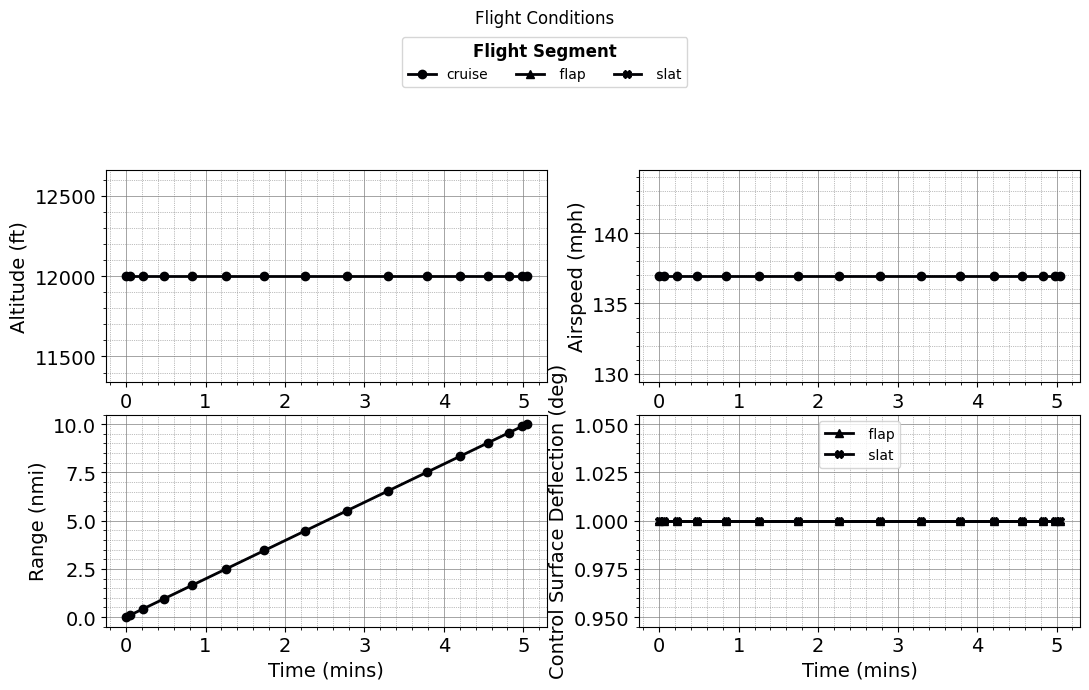

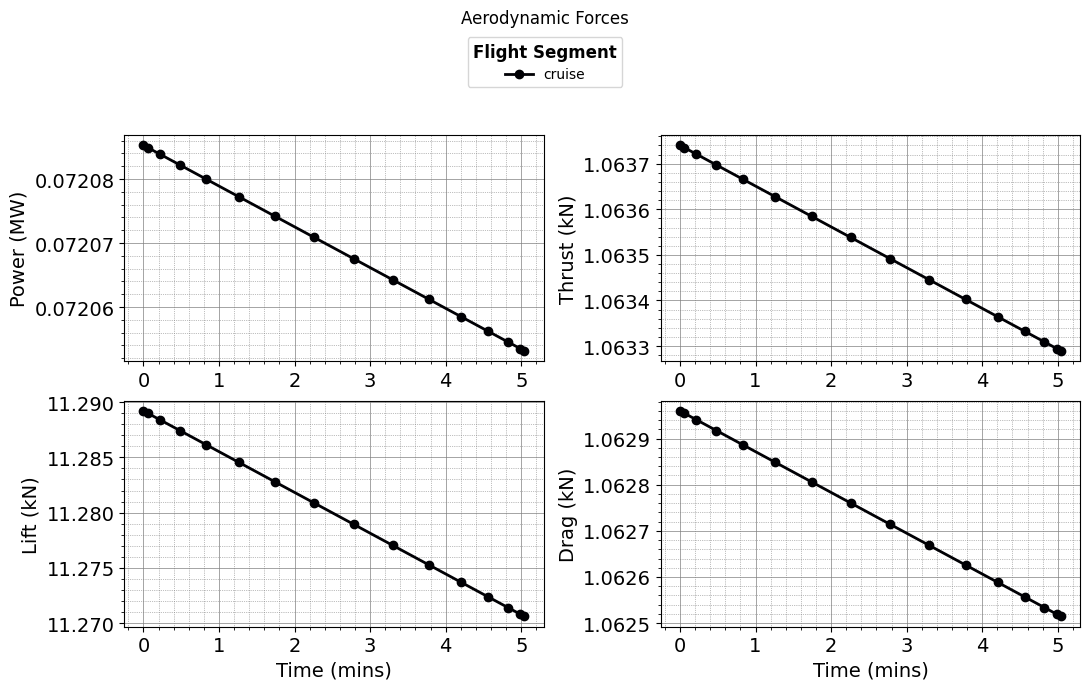

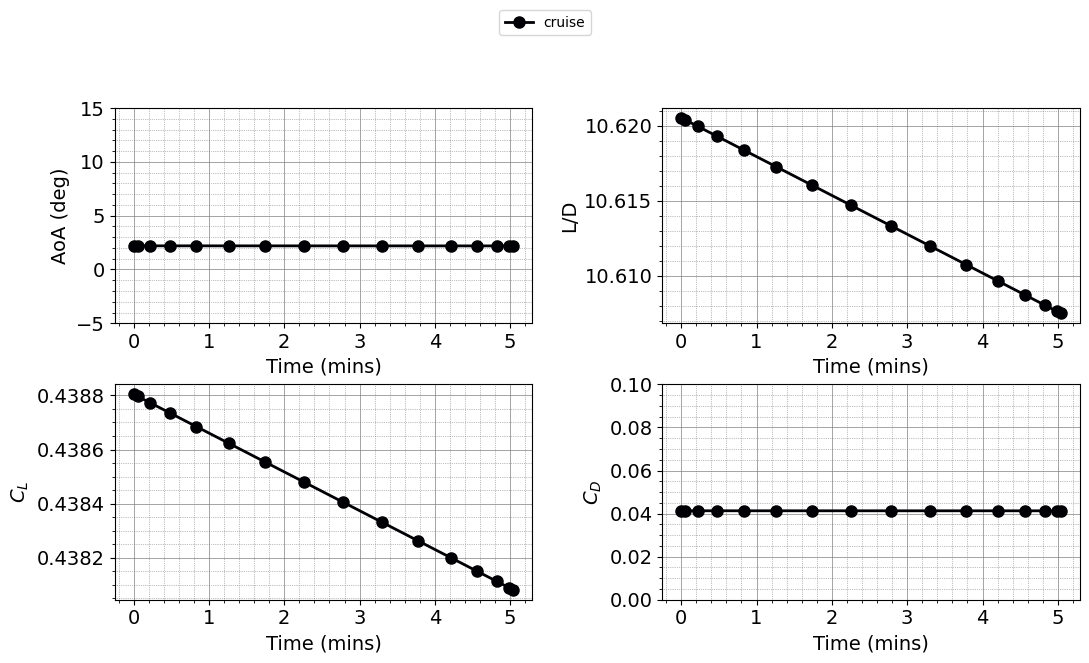

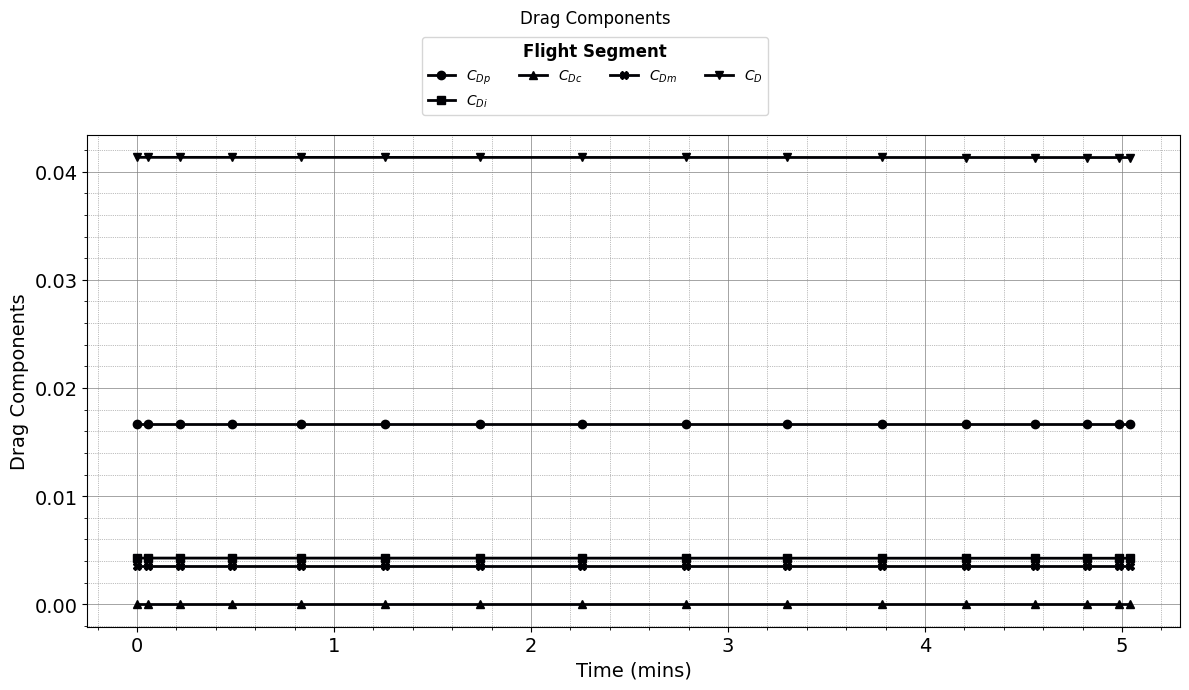

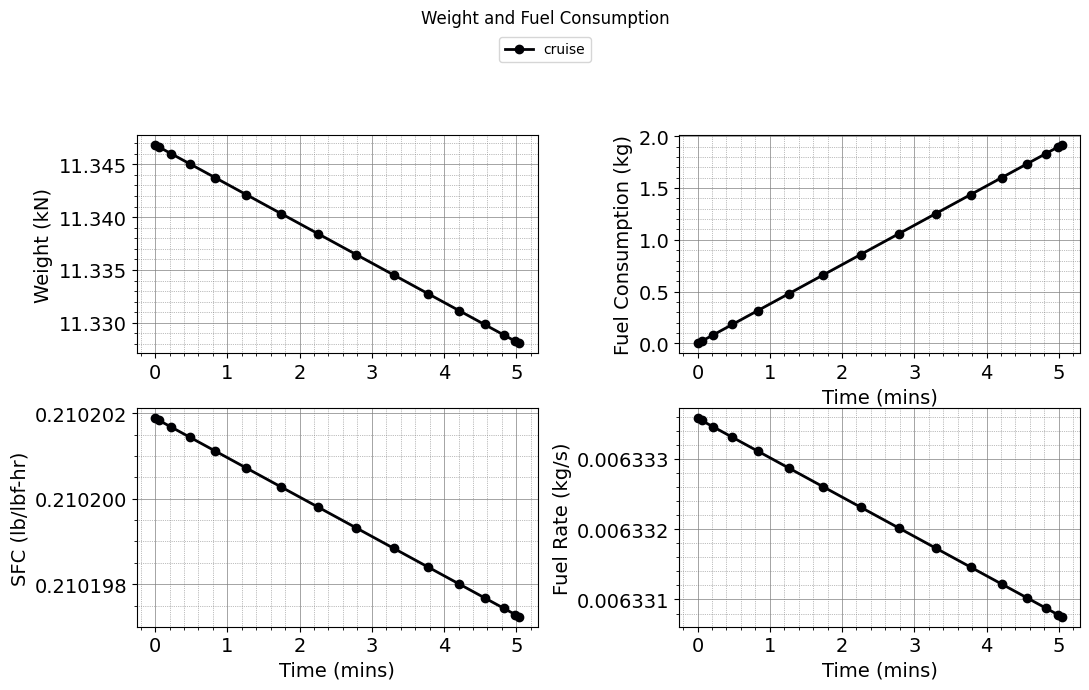

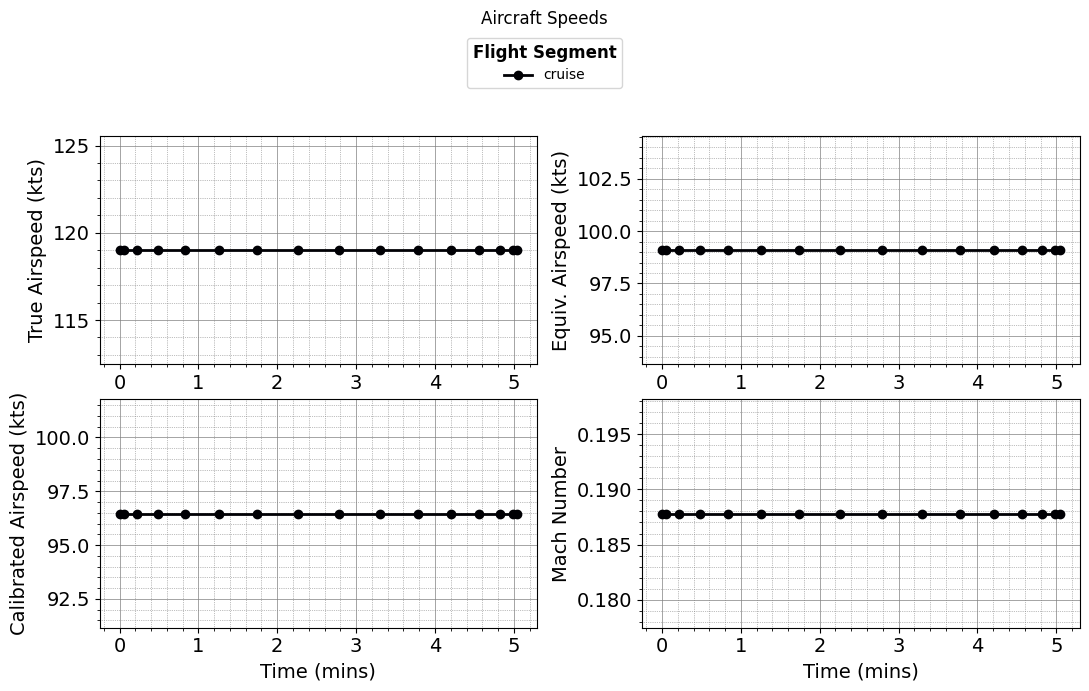

In [18]:

# vehicle data
vehicle  = vehicle_setup() 

# Set up vehicle configs
configs  = configs_setup(vehicle)

# create analyses
analyses = analyses_setup(configs)

# mission analyses
mission  = mission_setup(analyses) 

# create mission instances (for multiple types of missions)
missions = missions_setup(mission) 
    
# mission analysis 
results = missions.base_mission.evaluate()  

plot_mission(results)
